#### RESOURCES: 

- [https://drive.google.com/drive/folders/1ZjNrTb7T_SsOdck76qDcd5OHkFEU0C6Q](Lip Dataset)
- [https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full/data](Kaggle Clothing Dataset)
- [https://www.kaggle.com/datasets/hserdaraltan/deepfashion-inshop-clothes-retrieval] (DeepFashion-in-shop-clothes-retrieval)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch

import torch
import torchvision
import torchvision.transforms as T

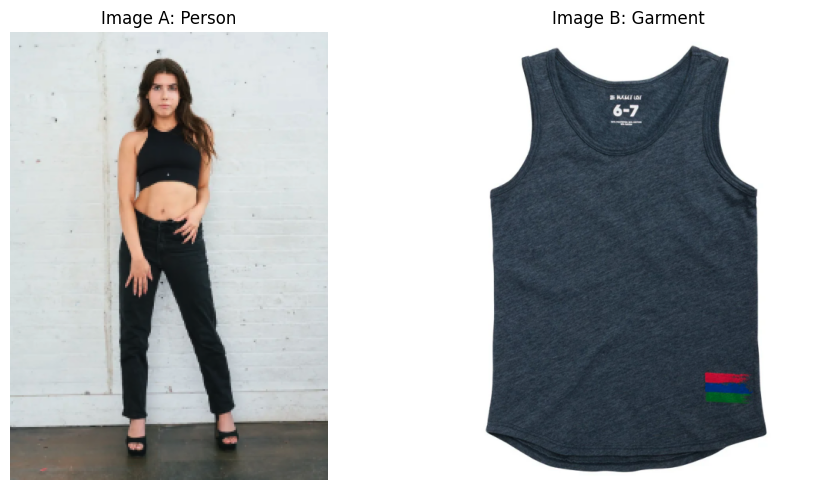

In [2]:
# Set paths
person_path = "sample-data/poses/pose1.png"   
garment_path = "sample-data/garments/tank-top.png"  

# Load images
img_person = Image.open(person_path).convert("RGB")
img_garment = Image.open(garment_path).convert("RGB")

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_person)
axs[0].set_title("Image A: Person")
axs[1].imshow(img_garment)
axs[1].set_title("Image B: Garment")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()


#### **CLASSIFY GARMENT TYPE**

In [3]:
import torch
import clip
from PIL import Image
import numpy as np

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define garment category prompts
garment_categories = ["t-shirt", "pants", "short dress", "long dress", "short skirt", "long skirt", "shorts", "blouse", "crop top", "tank top"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {g}") for g in garment_categories]).to(device)

In [4]:
# Load and preprocess garment image
img = Image.open(garment_path).convert("RGB")
image_input = preprocess(img).unsqueeze(0).to(device)

# Run CLIP
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

    logits_per_image, _ = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# Print results
for i, cat in enumerate(garment_categories):
    print(f"{cat:>12}: {probs[0][i]*100:.2f}%")

# Get top prediction
garment_type = garment_categories[np.argmax(probs)]
print("\n✅ Predicted Garment Type:", garment_type)

     t-shirt: 2.56%
       pants: 0.00%
 short dress: 0.00%
  long dress: 0.00%
 short skirt: 0.00%
  long skirt: 0.00%
      shorts: 0.03%
      blouse: 0.00%
    crop top: 0.12%
    tank top: 97.29%

✅ Predicted Garment Type: tank top


In [5]:
# !git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing.git
# !pip install opencv-python numpy torch torchvision yacs Pillow

### **HUMAN SEGMENTATION**

##### **USING DEEPLAB**

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet101

In [7]:
# Load pretrained DeepLabV3
model = deeplabv3_resnet101(pretrained=True).eval()

# Define image transforms (normalize, resize, etc.)
preprocess = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Load your image
img = Image.open(person_path).convert("RGB")

# Preprocess
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

# Run inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # shape: [21, H, W]
    prediction = output.argmax(0)           # shape: [H, W]


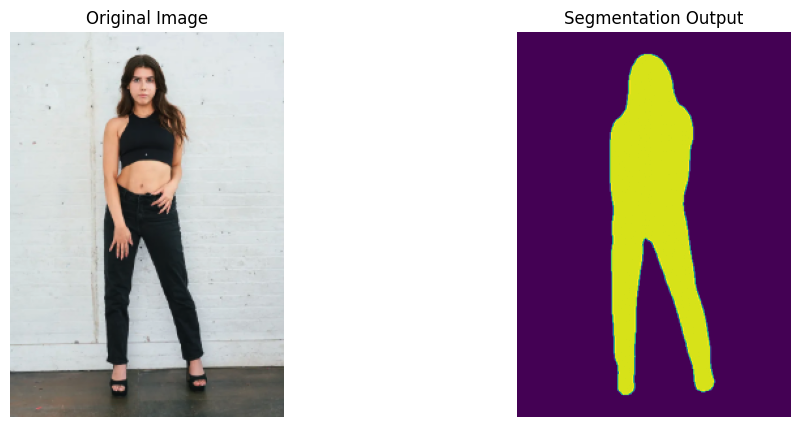

In [9]:
# Resize prediction to match original image
seg_mask = prediction.byte().cpu().numpy()
seg_mask_resized = Image.fromarray(seg_mask).resize(img.size)

# Overlay or display
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_mask_resized)
plt.title("Segmentation Output")
plt.axis("off")
plt.show()


#### **USING SINGLE-HUMAN-PARSING-LIP Model**

https://github.com/Yukun-Huang/Single-Human-Parsing-LIP?tab=readme-ov-file

In [10]:
import sys
sys.path.append('Single-Human-Parsing-LIP')

In [11]:
import torch
from net.pspnet import PSPNet
from collections import OrderedDict

# Step 1: Define model architecture (as done in the repo)
model = PSPNet(n_classes=20, backend='resnet50', pretrained=False)

# Step 2: Load checkpoint
checkpoint_path = "Single-Human-Parsing-LIP/PSPNet_last"
raw_ckpt = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if using GPU

# Step 3: Handle DataParallel if needed (strip 'module.' prefix)
new_state_dict = OrderedDict()
for k, v in raw_ckpt.items():
    name = k.replace("module.", "")  # remove 'module.' from key name
    new_state_dict[name] = v

# Step 4: Load weights into the model
model.load_state_dict(new_state_dict)
model.eval()  # set to evaluation mode

print("✅ PSPNet model loaded and ready for inference!")


✅ PSPNet model loaded and ready for inference!


/var/folders/2h/ttz38zd951b4w0q9zs208g7w0000gn/T/ipykernel_95872/938979784.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_ckpt = torch.load(checkpoint_path, map_lo

In [12]:
torch.save(model.state_dict(), "Single-Human-Parsing-LIP/PSPNet_cleaned.pth")

In [13]:
model.load_state_dict(torch.load("Single-Human-Parsing-LIP/PSPNet_cleaned.pth"))
model.eval()


/var/folders/2h/ttz38zd951b4w0q9zs208g7w0000gn/T/ipykernel_95872/2272721496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Single-Huma

PSPNet(
  (feats): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

Segmentation logits shape: torch.Size([1, 20, 480, 480])
Prediction map shape: (480, 480)


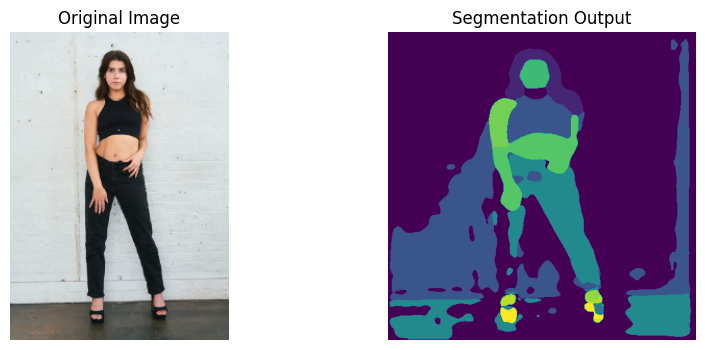

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import torch

# Load image
image = Image.open(person_path).convert('RGB')

# LIP-style preprocessing
transform = T.Compose([
    T.Resize((473, 473)),  # LIP default input size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # add batch dim

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    logits = output[0]
    print("Segmentation logits shape:", logits.shape)
    pred = torch.argmax(logits.squeeze(), dim=0).cpu().numpy()
    print("Prediction map shape:", pred.shape)

# Visualize result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.title("Segmentation Output")
plt.axis("off")
plt.show()


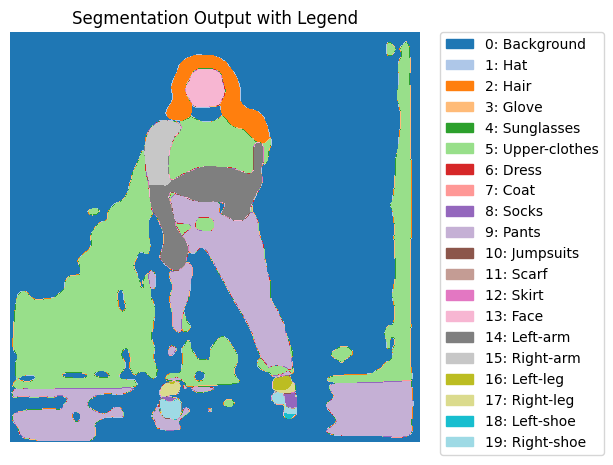

In [18]:
import matplotlib.patches as mpatches

# Define label names and colors (20 classes)
LIP_LABELS = {
     0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Glove', 4: 'Sunglasses',
     5: 'Upper-clothes', 6: 'Dress', 7: 'Coat', 8: 'Socks', 9: 'Pants',
    10: 'Jumpsuits', 11: 'Scarf', 12: 'Skirt', 13: 'Face', 14: 'Left-arm',
    15: 'Right-arm', 16: 'Left-leg', 17: 'Right-leg', 18: 'Left-shoe', 19: 'Right-shoe'
}

# Create a fixed color map (20 unique colors)
cmap = plt.get_cmap('tab20', 20)  # tab20 has 20 distinct colors

# Plot with colorbar legend
plt.figure(figsize=(10, 5))
plt.imshow(pred, cmap=cmap, vmin=0, vmax=19)
plt.title("Segmentation Output with Legend")
plt.axis("off")

# Create patches as legend entries
patches = [mpatches.Patch(color=cmap(i), label=f"{i}: {LIP_LABELS[i]}") for i in range(20)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


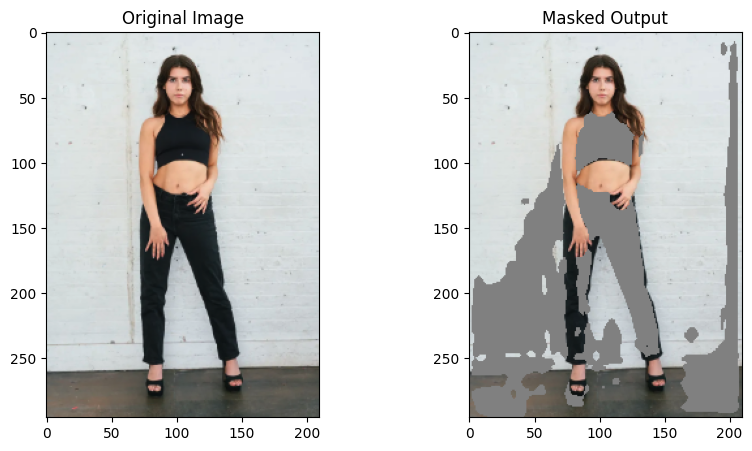

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pred` is your segmentation map from the model
# And `garment_class` is the string predicted by CLIP (e.g., "shirt", "dress", "pants")

# Mapping from label index to category (based on LIP dataset)
LIP_LABELS = {
    0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Glove', 4: 'Sunglasses',
    5: 'Upper-clothes', 6: 'Dress', 7: 'Coat', 8: 'Socks', 9: 'Pants',
    10: 'Jumpsuits', 11: 'Scarf', 12: 'Skirt', 13: 'Face', 14: 'Left-arm',
    15: 'Right-arm', 16: 'Left-leg', 17: 'Right-leg', 18: 'Left-shoe', 19: 'Right-shoe'
}

# Reverse the dictionary for label lookup
LABEL_NAMES_TO_IDX = {v.lower(): k for k, v in LIP_LABELS.items()}

# Define rule-based masking function
def generate_mask(pred, garment_class):
    garment_class = garment_class.lower()
    mask = np.zeros_like(pred, dtype=np.uint8)

    # Rules for which labels to mask
    if 'dress' in garment_class:
        target_labels = ['upper-clothes', 'coat', 'pants', 'skirt']
    elif 'shirt' in garment_class or 'top' in garment_class:
        target_labels = ['upper-clothes', 'coat']
    elif 'pants' in garment_class or 'trousers' in garment_class:
        target_labels = ['pants', 'skirt', 'jumpsuits']
    elif 'shorts' in garment_class:
        target_labels = ['pants', 'skirt']
    elif 'skirt' in garment_class:
        target_labels = ['skirt', 'pants']
    else:
        target_labels = []

    # Convert label names to indices
    label_indices = [LABEL_NAMES_TO_IDX[lbl] for lbl in target_labels if lbl in LABEL_NAMES_TO_IDX]

    for lbl in label_indices:
        mask[pred == lbl] = 255  # Mark this region in the mask

    return mask

# Placeholder example
# mask = generate_mask(pred, garment_class="dress")

# To visualize:
def overlay_mask_on_image(image_np, mask):
    """Gray out the masked area on the original image."""
    overlaid = image_np.copy()
    overlaid[mask == 255] = [128, 128, 128]
    return overlaid

# Ready to move forward!
"Masking pipeline and overlay utilities defined — ready to test with your image and garment class!"


mask = generate_mask(pred, garment_class="dress")

import cv2

# Resize mask to match original image size
resized_mask = cv2.resize(mask, (image.size[0], image.size[1]), interpolation=cv2.INTER_NEAREST)

# Then overlay it
overlaid = overlay_mask_on_image(np.array(image), resized_mask)



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(overlaid)
plt.title("Masked Output")
plt.show()

